<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes_SingleSource_fixedX/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 17 08:02:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = False
BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
LEARNING_RATE = 2e-6
EPOCHS = 1000
PATIENCE =13
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 4
OUTPUT_AB = 2
OUTPUT_Y = 1
OUTPUT_D = 1

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = - val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Conv2d(16, 16, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 16
            
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 64

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 128
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 256

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 512
            
        )
        self.fcc_ab = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_AB)
        )
        self.fcc_xy = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_Y)   
        )
        self.fcc_d = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, OUTPUT_D)
        )
    def forward(self, x):
        output = self.cnn(x)
        feature_map = output.view(output.size(0), -1)
        ab = self.fcc_ab(feature_map)
        a = ab[:, :1]
        b = ab[:, 1:]
        xy = self.fcc_xy(feature_map)
        d = self.fcc_d(feature_map)
        return (a, b, xy, d)

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = 'singlesource_class_fixed_x_trial2'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = os.path.join(DRIVE_PATH, 'Results', 'SingleSource_ByClasses_Fixed_X', 'traindata_Size_37250', 'checkpoint.pt')
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [0]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

In [0]:
#valsets = []
#for f in tqdm(os.listdir(VAL_PATH_LABEL)):
#  path  = os.path.join(VAL_PATH_LABEL, f)
#  valset = DataCaller_Excel(path, IMG_SIZE)
#  print(valset.__len__())
#  valsets.append(valset)

#valset = ConcatDataset(valsets)


In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [0]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    #x = x.astype(int)
    print(x)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==1:
      break

[[[[-3.9667125e+00 -2.9482124e+00 -4.9188715e-01 ... -3.3561943e+01
    -3.4355080e+01 -3.4646435e+01]
   [-3.9667125e+00 -2.1430957e+00  1.1118392e+00 ... -2.2712637e+01
    -2.3413185e+01 -2.3698402e+01]
   [-3.9667125e+00 -1.3941143e+00  2.4756534e+00 ... -1.2013984e+01
    -1.2239395e+01 -1.2361705e+01]
   ...
   [-3.9667125e+00 -4.6007781e+00 -4.0055237e+00 ... -3.6182941e+01
    -3.6287033e+01 -3.6315369e+01]
   [-3.9667125e+00 -3.7820714e+00 -2.2761238e+00 ... -2.7370880e+01
    -2.8011408e+01 -2.8273043e+01]
   [-3.9667125e+00 -2.9482124e+00 -4.9188715e-01 ... -3.3561943e+01
    -3.4355080e+01 -3.4646435e+01]]]


 [[[ 8.2157402e+00  8.0516548e+00  7.7737722e+00 ... -2.7975470e+01
    -2.8539129e+01 -2.8741306e+01]
   [ 8.2157402e+00  8.3792038e+00  8.3635359e+00 ... -2.0340559e+01
    -2.0954676e+01 -2.1194862e+01]
   [ 8.2157402e+00  8.6632643e+00  8.7897158e+00 ... -9.9200315e+00
    -1.0211844e+01 -1.0346242e+01]
   ...
   [ 8.2157402e+00  7.2732229e+00  6.0924540e+00 ... -2

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
def get_loss(a, b, y, d, label_a, label_b, label_y, label_d, weight):
  # a,b : 1 x 21
  # xy : 1 x 2
  # d : 1 x 10
  a = a.to(device)
  b = b.to(device)
  y = y.to(device)
  d = d.to(device)

  y = y.view(len(y))

  weight = weight.to(device)

  #change shape and form of labels
  label_a = label_a.view(len(label_a))
  label_b = label_b.view(len(label_b))
  label_d = label_d.view(len(label_d))
  label_a = label_a.type(torch.cuda.LongTensor)
  label_b = label_b.type(torch.cuda.LongTensor)
  label_d = label_d.type(torch.cuda.LongTensor)

  label_y = label_y.view(len(label_y))

  # classes should be 0 ~ N - 1
  # class N means that the length is ( N + 1 ) * lambda 
  #x = torch.ones(len(label_a))
  #x = x.to(device)
  #x = x.type(torch.cuda.LongTensor)

  #label_a = label_a - x
  #label_b = label_b - x

  #y = torch.ones(len(label_d))
  #y = y.to(device)
  #y = y.type(torch.cuda.LongTensor)
  
  #label_d = label_d - y

  #define criterion
  crit1 = nn.CrossEntropyLoss()
  crit2 = nn.CrossEntropyLoss()
  crit3 = nn.MSELoss()
  crit4 = nn.CrossEntropyLoss()

  loss1 = crit1(a, label_a)
  loss2 = crit2(b, label_b)
  loss3 = crit3(y, label_y)
  loss4 = crit4(d, label_d)
  
  return loss1 * weight[0]  + loss2 * weight[1] + loss3 * weight[2] + loss4 * weight[3]



In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1.0, 1.0, 1.1, 1.1])

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []

    #train_errors = []
    #val_errors = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    x = x.to(device)
                    y = y.to(device)

                    pred = net(x)
                    loss = weighted_mse(pred, y weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    train_losses.append(loss.item())

                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    pred = net(val_x)
                    loss = get_loss(pred, val_y, weight)
                    val_losses.append(loss.item())

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                

                train_losses = []
                val_losses = []


                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [0]:
net = Net()
#print(net)


In [0]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)


  0%|          | 1/1000 [00:08<2:25:37,  8.75s/it]


loss :  73.3291297343105 val loss :  69.93265643018357 

Validation loss decreased (inf --> 69.932656).  Saving model ...



  0%|          | 2/1000 [00:17<2:26:11,  8.79s/it]


loss :  54.92330539396024 val loss :  30.650955788632658 

Validation loss decreased (69.932656 --> 30.650956).  Saving model ...



  0%|          | 3/1000 [00:26<2:26:04,  8.79s/it]


loss :  28.109347753615175 val loss :  20.875851783346622 

Validation loss decreased (30.650956 --> 20.875852).  Saving model ...



  0%|          | 4/1000 [00:35<2:25:40,  8.78s/it]


loss :  22.465151681719234 val loss :  17.96967383648487 

Validation loss decreased (20.875852 --> 17.969674).  Saving model ...



  0%|          | 5/1000 [00:43<2:24:46,  8.73s/it]


loss :  20.339359090226523 val loss :  17.041196955011245 

Validation loss decreased (17.969674 --> 17.041197).  Saving model ...



  1%|          | 6/1000 [00:52<2:23:40,  8.67s/it]


loss :  19.277042979877706 val loss :  16.13094472885132 

Validation loss decreased (17.041197 --> 16.130945).  Saving model ...



  1%|          | 7/1000 [01:01<2:23:35,  8.68s/it]


loss :  18.479173234288726 val loss :  15.730537607314739 

Validation loss decreased (16.130945 --> 15.730538).  Saving model ...



  1%|          | 8/1000 [01:09<2:22:59,  8.65s/it]


loss :  17.921830734370445 val loss :  15.794589813719405 

EarlyStopping counter: 1 out of 13



  1%|          | 9/1000 [01:18<2:22:35,  8.63s/it]


loss :  17.43807734132378 val loss :  15.016311168670654 

Validation loss decreased (15.730538 --> 15.016311).  Saving model ...



  1%|          | 10/1000 [01:26<2:21:57,  8.60s/it]


loss :  17.23856239183254 val loss :  14.887792475680088 

Validation loss decreased (15.016311 --> 14.887792).  Saving model ...



  1%|          | 11/1000 [01:35<2:21:52,  8.61s/it]


loss :  16.61348556116294 val loss :  14.613680240955759 

Validation loss decreased (14.887792 --> 14.613680).  Saving model ...



  1%|          | 12/1000 [01:43<2:21:32,  8.60s/it]


loss :  16.454034430155822 val loss :  14.454388253232265 

Validation loss decreased (14.613680 --> 14.454388).  Saving model ...



  1%|▏         | 13/1000 [01:52<2:20:52,  8.56s/it]


loss :  16.099901078436613 val loss :  14.467298264199115 

EarlyStopping counter: 1 out of 13



  1%|▏         | 14/1000 [02:00<2:20:11,  8.53s/it]


loss :  15.777332378224738 val loss :  13.77599349935004 

Validation loss decreased (14.454388 --> 13.775993).  Saving model ...



  2%|▏         | 15/1000 [02:09<2:19:44,  8.51s/it]


loss :  15.764437607679321 val loss :  13.86017433125922 

EarlyStopping counter: 1 out of 13



  2%|▏         | 16/1000 [02:17<2:19:37,  8.51s/it]


loss :  15.428439382128241 val loss :  13.680910567019849 

Validation loss decreased (13.775993 --> 13.680911).  Saving model ...



  2%|▏         | 17/1000 [02:26<2:19:12,  8.50s/it]


loss :  15.222604060060041 val loss :  14.268122338234111 

EarlyStopping counter: 1 out of 13



  2%|▏         | 18/1000 [02:34<2:18:51,  8.48s/it]


loss :  14.978236903511517 val loss :  13.489373765093214 

Validation loss decreased (13.680911 --> 13.489374).  Saving model ...



  2%|▏         | 19/1000 [02:43<2:18:42,  8.48s/it]


loss :  14.877561098026439 val loss :  14.198699991753761 

EarlyStopping counter: 1 out of 13



  2%|▏         | 20/1000 [02:51<2:18:58,  8.51s/it]


loss :  14.844726424646604 val loss :  14.435085732886131 

EarlyStopping counter: 2 out of 13



  2%|▏         | 21/1000 [03:00<2:18:54,  8.51s/it]


loss :  14.517975900975449 val loss :  13.341610705598871 

Validation loss decreased (13.489374 --> 13.341611).  Saving model ...



  2%|▏         | 22/1000 [03:08<2:18:07,  8.47s/it]


loss :  14.400900278046233 val loss :  13.75656439395661 

EarlyStopping counter: 1 out of 13



  2%|▏         | 23/1000 [03:17<2:17:53,  8.47s/it]


loss :  14.309113830186744 val loss :  13.273778225513215 

Validation loss decreased (13.341611 --> 13.273778).  Saving model ...



  2%|▏         | 24/1000 [03:25<2:17:44,  8.47s/it]


loss :  13.985405952444573 val loss :  13.17815798901497 

Validation loss decreased (13.273778 --> 13.178158).  Saving model ...



  2%|▎         | 25/1000 [03:34<2:17:17,  8.45s/it]


loss :  13.908227312056374 val loss :  13.364153517053483 

EarlyStopping counter: 1 out of 13



  3%|▎         | 26/1000 [03:42<2:17:01,  8.44s/it]


loss :  13.754050135047516 val loss :  12.81035566329956 

Validation loss decreased (13.178158 --> 12.810356).  Saving model ...



  3%|▎         | 27/1000 [03:50<2:16:39,  8.43s/it]


loss :  13.435936289375991 val loss :  12.217896684687188 

Validation loss decreased (12.810356 --> 12.217897).  Saving model ...



  3%|▎         | 28/1000 [03:59<2:16:14,  8.41s/it]


loss :  13.42012972289352 val loss :  12.924115728824697 

EarlyStopping counter: 1 out of 13



  3%|▎         | 29/1000 [04:07<2:15:59,  8.40s/it]


loss :  13.265570262032098 val loss :  13.119030130670426 

EarlyStopping counter: 2 out of 13



  3%|▎         | 30/1000 [04:16<2:16:34,  8.45s/it]


loss :  12.953562837076413 val loss :  12.403347624109147 

EarlyStopping counter: 3 out of 13



  3%|▎         | 31/1000 [04:24<2:16:22,  8.44s/it]


loss :  12.718798046993419 val loss :  12.311967230857686 

EarlyStopping counter: 4 out of 13



  3%|▎         | 32/1000 [04:33<2:16:11,  8.44s/it]


loss :  12.646150823453027 val loss :  12.153058949937211 

Validation loss decreased (12.217897 --> 12.153059).  Saving model ...



  3%|▎         | 33/1000 [04:41<2:15:50,  8.43s/it]


loss :  12.51978989856503 val loss :  11.586838336701089 

Validation loss decreased (12.153059 --> 11.586838).  Saving model ...



  3%|▎         | 34/1000 [04:49<2:15:36,  8.42s/it]


loss :  12.392825914785195 val loss :  11.243304146097062 

Validation loss decreased (11.586838 --> 11.243304).  Saving model ...



  4%|▎         | 35/1000 [04:58<2:15:32,  8.43s/it]


loss :  12.078858033175717 val loss :  12.136351270878569 

EarlyStopping counter: 1 out of 13



  4%|▎         | 36/1000 [05:06<2:15:16,  8.42s/it]


loss :  12.114031456658061 val loss :  11.418611704035008 

EarlyStopping counter: 2 out of 13



  4%|▎         | 37/1000 [05:15<2:15:09,  8.42s/it]


loss :  11.880227839777255 val loss :  11.570294268587803 

EarlyStopping counter: 3 out of 13



  4%|▍         | 38/1000 [05:23<2:14:47,  8.41s/it]


loss :  11.888602262424632 val loss :  12.26088443208248 

EarlyStopping counter: 4 out of 13



  4%|▍         | 39/1000 [05:31<2:14:56,  8.43s/it]


loss :  11.730834623083684 val loss :  11.950343700165444 

EarlyStopping counter: 5 out of 13



  4%|▍         | 40/1000 [05:40<2:15:50,  8.49s/it]


loss :  11.604365649946493 val loss :  12.683400387459614 

EarlyStopping counter: 6 out of 13



  4%|▍         | 41/1000 [05:49<2:15:42,  8.49s/it]


loss :  11.528920840878058 val loss :  12.524632783646279 

EarlyStopping counter: 7 out of 13



  4%|▍         | 42/1000 [05:57<2:15:05,  8.46s/it]


loss :  11.426940128701558 val loss :  11.656987332283183 

EarlyStopping counter: 8 out of 13



  4%|▍         | 43/1000 [06:06<2:15:19,  8.48s/it]


loss :  11.466081309092553 val loss :  11.302333086094958 

EarlyStopping counter: 9 out of 13



  4%|▍         | 44/1000 [06:14<2:15:05,  8.48s/it]


loss :  11.325504021621994 val loss :  10.733477338831475 

Validation loss decreased (11.243304 --> 10.733477).  Saving model ...



  4%|▍         | 45/1000 [06:22<2:14:39,  8.46s/it]


loss :  11.348401189415375 val loss :  10.933552757222602 

EarlyStopping counter: 1 out of 13



  5%|▍         | 46/1000 [06:31<2:14:29,  8.46s/it]


loss :  11.23407471349454 val loss :  12.507579428084354 

EarlyStopping counter: 2 out of 13



  5%|▍         | 47/1000 [06:39<2:14:16,  8.45s/it]


loss :  11.01191483572196 val loss :  11.742131131760617 

EarlyStopping counter: 3 out of 13



  5%|▍         | 48/1000 [06:48<2:13:53,  8.44s/it]


loss :  11.074449958394489 val loss :  11.802696111354422 

EarlyStopping counter: 4 out of 13



  5%|▍         | 49/1000 [06:56<2:14:02,  8.46s/it]


loss :  11.028012767222256 val loss :  11.312356928561597 

EarlyStopping counter: 5 out of 13



  5%|▌         | 50/1000 [07:05<2:14:02,  8.47s/it]


loss :  10.979297636244535 val loss :  11.20506970933143 

EarlyStopping counter: 6 out of 13



  5%|▌         | 51/1000 [07:13<2:13:49,  8.46s/it]


loss :  10.871159959743373 val loss :  11.771854248452694 

EarlyStopping counter: 7 out of 13



  5%|▌         | 52/1000 [07:22<2:13:31,  8.45s/it]


loss :  10.853834713239806 val loss :  12.455982086506296 

EarlyStopping counter: 8 out of 13



  5%|▌         | 53/1000 [07:30<2:13:22,  8.45s/it]


loss :  10.761603474617004 val loss :  12.146444838097755 

EarlyStopping counter: 9 out of 13



  5%|▌         | 54/1000 [07:38<2:13:04,  8.44s/it]


loss :  10.71218805798987 val loss :  11.191023532380449 

EarlyStopping counter: 10 out of 13



  6%|▌         | 55/1000 [07:47<2:12:46,  8.43s/it]


loss :  10.708911887842332 val loss :  11.890219815233921 

EarlyStopping counter: 11 out of 13



  6%|▌         | 56/1000 [07:55<2:12:24,  8.42s/it]


loss :  10.568969075713678 val loss :  11.853145842856549 

EarlyStopping counter: 12 out of 13

loss :  10.561377402730463 val loss :  11.472145912495066 

EarlyStopping counter: 13 out of 13
Early stopping


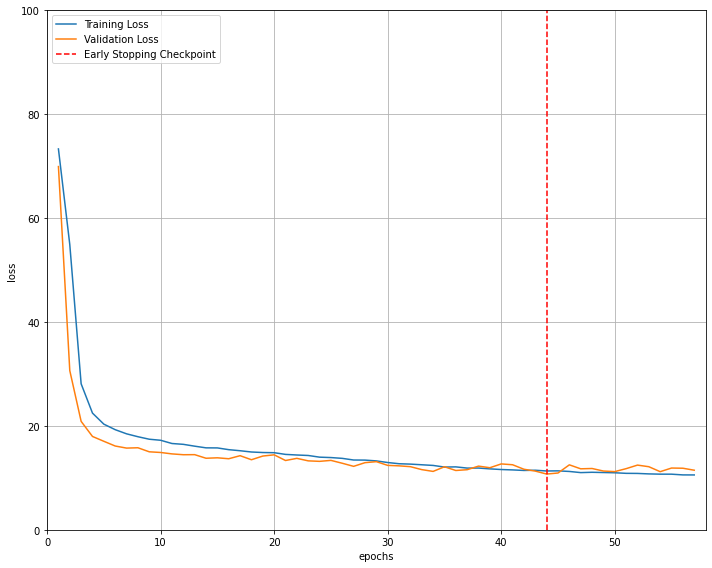

In [0]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            predict = []
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            pred = net(x)

            #get class of a, b, d
            #_, aa = a.max(1)
            #_, bb = b.max(1)
            #_, dd = d.max(1)

            pred.to("cpu")

            pred = np.array(pred)
            predictions.append(pred)
            

    #print(predictions)
    #print()
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [0]:
#testsets = []
#for f in tqdm(os.listdir(TEST_PATH_LABEL)):
#  path  = os.path.join(TEST_PATH_LABEL, f)
# testset = DataCaller_Excel(path, IMG_SIZE)
#  print(testset.__len__())
#  testsets.append(testset)

#testset = ConcatDataset(testsets)

In [0]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
trained_net = Net()
trained_net.load_state_dict(torch.load('checkpoint.pt'))
trained_net.to(device)
trained_net.eval()
test(trained_net)

In [0]:
testloader = DataLoader(testset, batch_size=1, shuffle=False)
#trained_net = Net()
load_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
load_net.to(device)
load_net.eval()
test(load_net)

NameError: ignored